# **실습. 베이직 seq2seq**

## **0.과제 이해하기**
seq2seq를 활용하여 숫자 시퀀스를 좌우 반전 시켜라!”
본격적인 활동에 앞서 지난 실습 내용을 복습해보자. 지난 활동은 RNN을 활용한 분류 작업으로, 어떤 시퀀스가 주어졌을 때 동일한 반쪽을 갖고 있는 다른 시퀀스를 찾아내는 것이었다. 이전 활동에서 살펴봤듯 RNN 모델 아키텍쳐는 순차적 데이터(sequence), 즉 텍스트와 같이 ‘순서’ 개념이 중요한 데이터를 다룰 때 유용하다. 이번 시간에는 RNN이 확장된 형태인 시퀀스 투 시퀀스(seq2seq) 모형을 배워볼 것이며, 실습 역시 지난 번과 마찬가지로 순차적 데이터인 시퀀스를 활용하는 활동이 될 것이다.

이번 실습의 과제는, 주어진 숫자 시퀀스를 좌우반전시키는 것이다. 컴퓨터 상에서 언어를 다룰 때, 언어를 변형해야 하는 상황을 자주 마주하게 된다. 이번 과제 역시 일종의 언어 변형 문제라 생각해볼 수 있으며, 그 내용은 간단하다. 일련의 숫자 시퀀스가 주어지면 seq2seq 모델을 활용하여 해당 시퀀스를 뒤집어 좌우반전시키면 된다.

>과제 예시  
$[2,4,7,1,3]→[3,1,7,4,2]$  
  

지난 활동에서와 마찬가지로, 우리는 시퀀스를 구성하는 각 숫자(0~9)를 one-hot 인코딩으로 나타낼 것이다. 지난 번과 다른 점은, 시퀀스의 시작과 끝을 나타내는 토큰 두 개, 즉 Start 토큰과 End 토큰을 추가적으로 사용할 것이라는 점이다. 여기서 Start 토큰은 숫자 10에, End 토큰은 숫자 11에 대응되도록 설정할 것이다. 이같은 방식으로 숫자를 새롭게 표현하면, 이하와 같이 (12,)의 shape을 가진 벡터가 12개 생성될 것이다.  

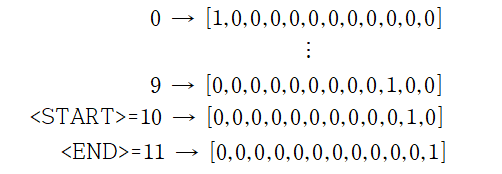



## **1. 배치(Batch) 생성하기**

본격적인 코드 작성에 앞서, 아래 코드를 통해 이번 실습에 필요한 세팅을 진행해보자.

In [1]:
from collections import defaultdict

import numpy as np

import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

우리는 효율적인 학습을 위해 여러 시퀀스에 대한 batch를 생성해볼 것이다. 이때 batch는 한국어 표현으로는 영어 발음 그대로 ‘배치’라고 한다. batch란, 학습 과정에서 효율을 높이고자 ‘입력 데이터를 일괄로 처리하기 위해 묶는 것’을 가리킨다.만든 batches는 학습 과정에서 모델에 전달될 것이다. 그렇다면 batch를 어떠한 형태로 구성하여 모델의 input으로 입력할 것인가? batch-size가 N이고 오리지널 데이터의 자리수 길이가 T-1이라 할 때, 우리는 (T,N,C=12)의 shape를 가진 one-hot 인코딩 배열이 되도록 batches를 만들 것이다.



---
(T,N,C=12)의 모양으로 batch를 구성하는 방식은, N을 0차원 자리에 두었었던 예전의 batch 구성 방식 (N,T,C)와 다른 것이다. 그러나 궁극적으로는 NumPy의 행렬곱 broadcasting 방식 에 의하여, 예전과 동일한 방식으로 내적을 수행하게 된다고 볼 수 있다. 아래 코드를 통해, (T,N,C) 모양의 batch와 (N,T,C) 모양의 batch가 각각 arr와의 행렬곱을 진행하면 궁극적으로는 두 결과가 동일함을 확인할 수 있다.

- 이때 numpy의 broadcasting 성질은 중요하므로, 잘 이해되지 않는다면 구글링을 통해 개념을 익혀보자.


```
T, N, C = 2, 3, 4
seq_then_batch = np.arange(T * N * C).reshape(T, N, C)

#예전의 batch 모양인 (N, T, 5) 만들기
batch_then_seq = seq_then_batch.transpose(1, 0, 2)

arr = np.arange(C * 5).reshape(C, 5)

# shape-(T, N, C) x shape-(C, 5) -> shape-(T, N, 5)
seq_then_batch = seq_then_batch @ arr
# shape-(N, T, C) x shape-(C, 5) -> shape-(N, T, 5)
batch_then_seq = batch_then_seq @ arr

np.all(seq_then_batch == batch_then_seq.transpose(1, 0, 2))

```


---





 위의 고려사항을 염두에 두고, 주어진 숫자 시퀀스(digit-sequences)에 대한 배치를 생성하는 아래의 함수 generate_batch를 살펴보자. (이때 숫자 시퀀스는 one-hot 인코딩을 거친 형태이다.) generate_batch 함수 및 코드에 대한 개괄적인 설명은, 주석으로 삽입할 시 셀이 너무 길어지므로 셀 바깥으로 빼두겠다. 직접 함수를 실행시켜보면서 함수의 기능을 직관적으로 이해해보도록 하자.

>generate_batch 함수란, 여러 숫자 시퀀스로 이루어진 batch를 생성하고 이에 대응하는 one-hot 인코딩을 만들어내는 함수이다.
>- 이때 각 숫자 시퀀스는 T-1의 길이를 가지며 END 토큰을 포함하지 않는다.
>- T-1의 값은 랜덤으로 생성된다.
    
    매개변수
    ----------
    seq_len_min : int, optional (default=1)
       가능한 패턴 길이 가운데 가장 짧은 것.
       start 토큰과 end 토큰이 포함되지 않음
       
    seq_len_max : int, optional (default=20)
       가능한 패턴 길이 가운데 가장 긴 것,
       start 토큰과 end 토큰이 포함되지 않음
       
    batch_size : int, optional (default=10)
        배치 크기. 생성하는 sequence의 개수
    
    반환 값
    -------
    Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]
        1. one-hot 형태의 숫자 시퀀스들(end 토큰 포함); 모양-(T, N, 12)
        2. 오리지널 숫자 시퀀스들이 반전된 형태인, 타겟 숫자 시퀀스들(end 토큰을 포함); 모양-(T, N)
        3. 숫자들로 이루어진 오리지널 sequences; shape-(T-1, N)
    
    예시
    --------
    >>> generate_batch(2, 3, batch_size=2)
    (array([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], dtype=float32),
     array([[ 0,  6],
            [ 6,  3],
            [11, 11]]),
     array([[6, 3],
            [0, 6]]))




In [2]:
def generate_batch(seq_len_min=1, seq_len_max=20, batch_size=10):
    T_1 = np.random.randint(seq_len_min, seq_len_max + 1)
    digits = np.random.randint(0, 10, (T_1, batch_size))
    one_hot_x = np.zeros((T_1 + 1, batch_size, 12), dtype=np.float32)
    one_hot_x[np.arange(T_1).reshape(-1, 1), np.arange(batch_size), digits] = 1
    one_hot_x[-1, :, -1] = 1
    ends = np.full(batch_size, 11).reshape(1, -1)
    y = np.concatenate([digits[::-1], ends], axis=0)
    return one_hot_x, y, digits

각 코드를 분석하자면,  


```
T_1 = np.random.randint(seq_len_min, seq_len_max + 1)
    # T-1 값
    # 하나의 sequence를 랜덤으로 생성 ([seq_len_min, seq_len_max] 범위 내의 길이)

digits = np.random.randint(0, 10, (T_1, batch_size))
    # [0-9] 범위의 숫자들로 구성된 (T-1, N) 크기의 시퀀스를 랜덤으로 생성하여, `digits`에 저장
    # N: 우리의 모델이 번역할, T-1 길이의 정수 값 시퀀스 N개를 나타냄
    #
    # E.g. 만약 T-1 = 3, N = 2 일 때 생성하는 배열:
    #
    #  array([[3, 9],
    #         [2, 5],
    #         [9, 3]])
    # seq-0: 3, 2, 9
    # seq-1: 9, 5, 3

one_hot_x = np.zeros((T_1 + 1, batch_size, 12), dtype=np.float32)
    # 배열 `one_hot_x`
    # 0으로 구성된 배열 하나(one-hot 인코딩 sequences를 채우는 역할)를 생성
    # 배열의 크기: (T, N, 12) (이때 N = batch-size)
    # 데이터 타입: float-32
    # 배열 길이: T (source sequence가 <end> 토큰을 포함하고 <start>를 포함하지 않기 때문)

one_hot_x[np.arange(T_1).reshape(-1, 1), np.arange(batch_size), digits] = 1
    # `digits`의 역할: `one_hot_x`을 적절한 one-hot encodings으로 채우는 데 사용
    # 이하의 두 방식 중 하나를 통해 구현
    # 1_추가적인 인덱싱: 0으로 채워진 3차원 배열 가운데, 1이 들어가야 할 자리에 1 입력
    # one_hot_x[np.arange(T_1).reshape(-1, 1), np.arange(batch_size), digits] = 1
    #
    # 2_for 반복문 사용:
    # for ind in np.ndindex(digits.shape):
    #     one_hot_x[ind + (digits[ind],)] = 1

one_hot_x[-1, :, -1] = 1
    # `one_hot_x`에서 모든 batches에 대한 마지막 토큰에 <END>를 위치시킴
    # <END> 토큰은 이 행렬에서 T번째 시퀀스 엔트리와 12번째 인코딩 지점에 위치함
    # 이 선택된 subarray를 1로 지정하고자 함.

ends = np.full(batch_size, 11).reshape(1, -1)
    # 타겟 시퀀스에 사용할 <END> 토큰 생성
y = np.concatenate([digits[::-1], ends], axis=0)
    # input 시퀀스가 뒤집힌 형태인 타겟 시퀀스 생성
    # 타겟 시퀀스의 shape는 (T, N), T번째 행에 <END>토큰인 `11` 존재

return one_hot_x, y, digits
    # 조건에 부합하는 행렬 결과 반환

```



지금까지 '1. 배치(Batch) 생성하기' 파트를 통해 batch를 생성해보았다. 이렇게 생성한 batches를 input으로 넣어주면 학습의 효율이 높아질 수 있다. 지난 시간에 배운 RNN 모델 역시 이러한 batches를 학습과정에 활용하였으며, 우리가 이번 노트에서 다룰 "시퀀스 투 시퀀스", 이른바 seq2seq 모델 역시 RNN을 구성요소로 취하기에 마찬가지로 batches를 활용할 예정이다.  

>본 마크다운 파일에서는 실습 위주로 다루고자 하니, 본격적인 seq2seq 개념을 다루는 2(seq2seq 개념 만나기), 3(수식으로 seq2seq 이해하기)의 내용은 본책 3권을 참고하여 이해하도록 하자. 우리는 이제 실습과 관련된 '4. 코드로 seq2seq 표현하기'로 바로 넘어가볼 것이다.

In [3]:
one_hot_x, y , digits = generate_batch()

In [5]:
one_hot_x.shape, y.shape , digits.shape # 10의 의미 : batch_size, 12의 의미 : batch_size에 end와 start가 추가된것
                                        # 첫번째 항의 의미 : seq_len_min과 seq_len_max 사이의 랜덤한 값

((8, 10, 12), (8, 10), (7, 10))

In [6]:
one_hot_x[:,1,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [7]:
digits

array([[7, 9, 1, 5, 0, 9, 2, 4, 6, 2],
       [6, 7, 5, 4, 9, 3, 6, 7, 5, 2],
       [9, 3, 3, 0, 4, 7, 6, 3, 8, 9],
       [8, 5, 6, 1, 3, 6, 5, 9, 5, 3],
       [6, 8, 7, 4, 3, 1, 2, 1, 5, 7],
       [7, 8, 2, 1, 1, 6, 2, 8, 4, 2],
       [8, 4, 2, 7, 9, 7, 3, 0, 0, 4]])

In [8]:
y

array([[ 8,  4,  2,  7,  9,  7,  3,  0,  0,  4],
       [ 7,  8,  2,  1,  1,  6,  2,  8,  4,  2],
       [ 6,  8,  7,  4,  3,  1,  2,  1,  5,  7],
       [ 8,  5,  6,  1,  3,  6,  5,  9,  5,  3],
       [ 9,  3,  3,  0,  4,  7,  6,  3,  8,  9],
       [ 6,  7,  5,  4,  9,  3,  6,  7,  5,  2],
       [ 7,  9,  1,  5,  0,  9,  2,  4,  6,  2],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11]])

In [9]:
one_hot_x[:,:,:]

array([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0.,

## **2. 코드로 seq2seq 표현하기**

지금까지 인코딩과 디코딩 과정을 수식을 기반으로 분석해보았다. 이제는 코드로 표현해볼텐데, 이전 노트북의 RNN 클래스를 바탕으로 새로운 seq2seq 모델을 만들고 batches를 활용한 학습을 진행할 것이다. 우선, 아래 코드를 통해 output과 hidden descriptor를 모두 생성하는 simple-cell RNN을 구현해보자. 이때 주어진 코드를 수정할 필요는 없다.


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, dim_input, dim_recurrent, dim_output):
        """ RNN에 필요한 모든 레이어 초기 설정

        매개변수
        ----------
        dim_input: int
            RNN을 지나가는 데이터의 차원 (C)

        dim_recurrent: int
            RNN에 있는 hidden state의 차원 (D)

        dim_output: int
            RNN의 output의 차원 (K)
        """
        super(RNN, self).__init__()
        self.fc_x2h = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2h = nn.Linear(dim_recurrent, dim_recurrent, bias=False)
        self.fc_h2y = nn.Linear(dim_recurrent, dim_output)
        self.relu = nn.ReLU()


    def forward(self, x, h_t=None):
        """ RNN에 대한 완전한 순방향 패스(full forward pass)를 수행.

        매개변수
        ----------
        x: torch.Tensor, shape=(T, N, C)
            batch의 각 시퀀스에 대한 one-hot 인코딩

        h: Optional[torch.Tensor], shape=(1, N, D)
            초기 hidden dimension state h_0에 대한 옵션 설정
            지정되지 않을 경우 영행렬 할당.

        반환 값
        -------
        Tuple[y, h]
            y: torch.Tensor, shape=(T, N, K)
                각 RNN step에 대한 최종 분류 점수
            h: torch.Tensor, shape=(T, N, D)
                각 RNN step에서 계산된 hidden states (초기 상태 h_0는 제외)
        """
        N = x.shape[1]
        D = self.fc_h2h.weight.shape[0]

        # 최초 hidden state 값이 입력되지 않은 경우, 모든 원소를 0으로 초기화한다.
        if h_t is None:
            h_t = torch.zeros(1, N, D, dtype=torch.float32)


        h = []

        # for 문을 이용하여 x 내의 데이터를 한 스텝씩 꺼낸다.
        for t in range(x.shape[0]):
            h_t = self.relu(self.fc_x2h(x[t]) + self.fc_h2h(h_t))
            h.append(h_t)

        # 즉, RNN의 모든 hidden state를 하나의 행렬로 묶어서 return할 것이다. (torch.cat 기능 사용할 것)
        # https://pytorch.org/docs/stable/generated/torch.cat.html
        all_h = torch.cat(h, dim=0)

        # all_y는 T개의 예측 점수가 들어 있는 (T, K) 모양의 배열이다.
        # 각 점수들은 T개의 hidden descriptor로부터 각기 산출된다.
        all_y = self.fc_h2y(all_h)
        return all_y, all_h

이제 seq2seq 클래스를 작성해보자. 다행히 이 작업에 필요한 주요 요소들이 모두 RNN 클래스와 F.one_hot 함수 내에 존재하니, 이를 잘 활용하면 된다.

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, dim_input, dim_recurrent, dim_output):
        """ Seq2Seq 모델의 인코더와 디코더를 초기화

        매개변수
        ----------
        dim_input: int
            입력 데이터의 차원 (C)

        dim_recurrent: int
            인코더와 디코더의 hidden state 차원 (D)

        dim_output: int
            디코더의 출력 차원 (K)
        """
        super(Seq2Seq, self).__init__()
        self.encoder = RNN(dim_input, dim_recurrent, dim_output)
        self.decoder = RNN(dim_input, dim_recurrent, dim_output)

    def forward(self, x):
        """ Seq2Seq 모델의 순방향 패스를 수행

        매개변수
        ----------
        x: torch.Tensor, shape=(T, N, C)
            배치의 각 시퀀스에 대한 one-hot 인코딩 입력

        반환 값
        -------
        y: torch.Tensor, shape=(T, N, K)
            각 시퀀스의 디코딩된 출력
        """
        T, N, C = x.shape

        # 인코더를 통해 입력 시퀀스 x를 인코딩하고 마지막 hidden state를 얻음. 인코더의 출력은 필요하지 않음. hidden state만 return 받을 것
        _, enc_h = self.encoder(x)

        # 디코더의 초기 hidden state를 인코더의 마지막 hidden state로 설정
        h_t = enc_h[-1:]

        # 디코더의 출력을 저장할 리스트 초기화
        y = []

        # 디코더의 첫 번째 입력을 나타내는 start token 설정
        s_t = torch.zeros(1, N, C)
        # 가장 첫번째 step의 입력 토큰으로는 Start를 의미하는 [0, 0, ......., 1 , 0] 가 되어야 함
        s_t[:, :, -2] = 1

        # 타임스텝 T 동안 디코더를 반복 실행
        for _ in range(T):
            # 디코더에 현재 입력 s_t와 hidden state h_t를 전달하여 출력을 계산
            y_t, h_t = self.decoder(s_t, h_t)
            # 출력을 리스트에 추가
            y.append(y_t)

            # 다음 타임스텝의 입력을 현재 출력의 원-핫 인코딩으로 설정.
            s_t = F.one_hot(y_t.argmax(dim=-1), num_classes=12).float().unsqueeze(0)

        # 리스트 y를 텐서로 변환
        y = torch.cat(y, dim=0)
        return y

seq2seq 모델과 Adam Optimizer를 인스턴스로 실제화해보자.  
우선, Adam의 매개변수 recurrent_dim의 값의 경우 default인 50으로 시작해보자.

In [12]:
# 여기에 코드 작성
model = Seq2Seq(dim_input=12, dim_recurrent=50, dim_output=12)
optimizer = optim.Adam(model.parameters())

이번에는 학습을 위한 loop를 작성해보자. 이 loop는 softmax_crossentropy를 사용하여 loss를 계산할 것이다.

PyTorch의 nn.CrossEntropyLoss를 사용하여 손실을 계산할 때, 입력 데이터에 대해 아래의 조건을 충족해야 한다. 첫 번째 입력인 input의 shape은 (N, C)이고, 두 번째 입력인 target의 shape은 (N,)이어야 한다. 이를 우리 모델에 대입해보면,

1. 우리 모델의 output의 경우, 우리가 시퀀스에 대한 배치를 가지고 작업하고 있기 때문에, 그 shape이 (T, N, K)여야 한다. 또한, 정답 값(truth values)의 shape은 (T, N)이어야 합니다.

2. 우리의 input들을 nn.CrossEntropyLoss와 양립 가능하도록 만들기 위해, 우리는 input과 target을 각각 (T * N, C)와 (T * N)의 형태로 reshape할 수 있다. 이를 통해 손실 함수를 위한 새 버전을 재정의할 필요 없이, 토큰당 softmax-crossentropy 손실값을 계산하고 평균화할 수 있다.

이제, 만든 모델을 10000번 반복하여 학습시켜라. 이때 배치 크기는 100, 시퀀스의 길이 범위는 1에서 20 사이로 지정하겠다.

In [13]:
from IPython.display import clear_output
def plot_loss(losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

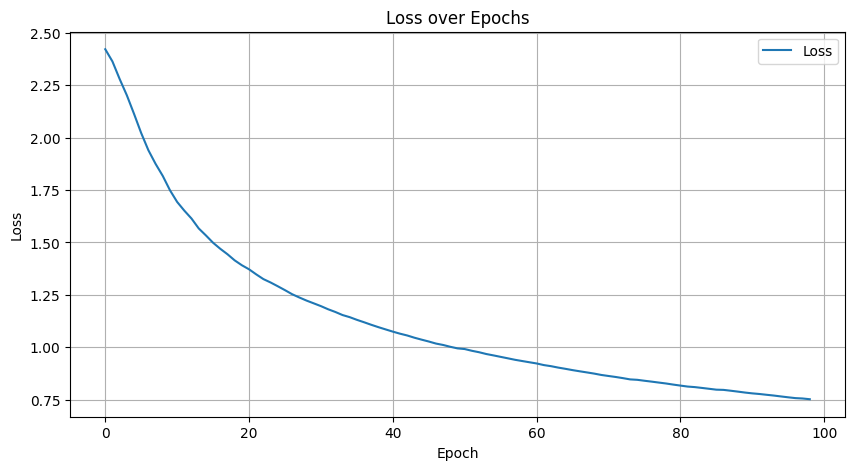

Epoch 9900/10000, Loss: 0.0313


In [14]:
# 여기에 코드 작성
batch_size = 100
num_epochs = 10000

losses = []
loss_average_list = []
for epoch in range(num_epochs):
    x, target, _ = generate_batch(batch_size=batch_size)
    x = torch.tensor(x, dtype=torch.float32)
    target = torch.tensor(target, dtype=torch.long)
    optimizer.zero_grad()
    output = model(x)
    loss = nn.CrossEntropyLoss()(output.view(-1, 12), target.view(-1))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % batch_size == 0 and epoch > 0:
        loss_average = np.mean(losses)
        loss_average_list.append(loss_average)
        plot_loss(loss_average_list)
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss:.4f}")

In [15]:
# 정확도 계산
length_total = defaultdict(int)
length_correct = defaultdict(int)

model.eval()
with torch.no_grad():
    for i in range(50000):
        if i % 5000 == 0:
            print(f"{i}번 test 진행")
        if i == (50000-1):
            print(f"{i}번 test 진행")
        x, target, sequence = generate_batch(1, 20, 1)

        x = torch.tensor(x, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.long)

        output = model(x)
        length_total[sequence.size] += 1
        if torch.all(output.argmax(dim=-1) == target):
            length_correct[sequence.size] += 1

0번 test 진행
5000번 test 진행
10000번 test 진행
15000번 test 진행
20000번 test 진행
25000번 test 진행
30000번 test 진행
35000번 test 진행
40000번 test 진행
45000번 test 진행
49999번 test 진행


아래 셀을 실행하여 길이가 다양한 시퀀스에서 모델의 정확도를 평가하라. seq2seq 모델은 기본 RNN과 어떻게 다른가? 놀라운 점은 무엇이며, 만약 그렇지 않다면 이러한 결과를 예상한 이유가 무엇인가? 당신의 생각을 다른 사람들과 논해보자.

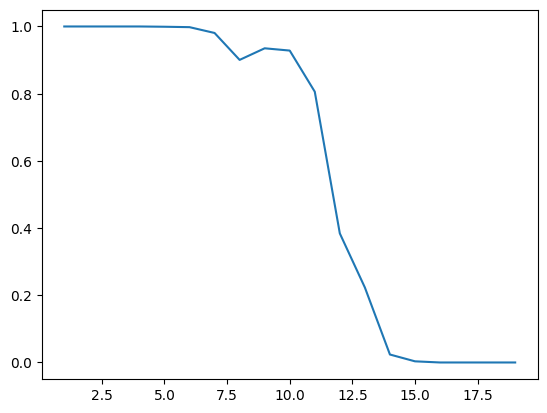

In [16]:
# 정확도 시각화
fig, ax = plt.subplots()
x, y = [], []
for i in range(1, 20):
    if length_total[i] > 0:
        x.append(i)
        y.append(length_correct[i] / length_total[i])
ax.plot(x, y);